<div style="
  background-color: #e3f2fd;
  padding: 15px;
  border-left: 6px solid #0d47a1;
  border-radius: 8px;
  font-family: 'Georgia', serif;
  color: #01579b;
  font-size: 28px;
  text-align: center;
  font-weight: bold;
">
  📚 Import Libraries
</div>

In [9]:
import torch
from torch import nn
from tqdm.auto import tqdm
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import random
import glob
import albumentations as A

import warnings
warnings.filterwarnings('ignore')

<div style="
  background-color: #e3f2fd;
  padding: 15px;
  border-left: 6px solid #0d47a1;
  border-radius: 8px;
  font-family: 'Georgia', serif;
  color: #01579b;
  font-size: 28px;
  text-align: center;
  font-weight: bold;
">
  🔍 Exploring The Data

</div>

In [13]:
# Look at the training, testing and validation data numbers
train_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/train/**/*.jpeg')
test_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/test/**/*.jpeg')
val_data = glob.glob('../input/chest-xray-pneumonia/chest_xray/val/**/*.jpeg')

print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")

Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images


In [14]:
DIR = "../input/chest-xray-pneumonia/chest_xray/"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 4273
Total Normal Images: 1583


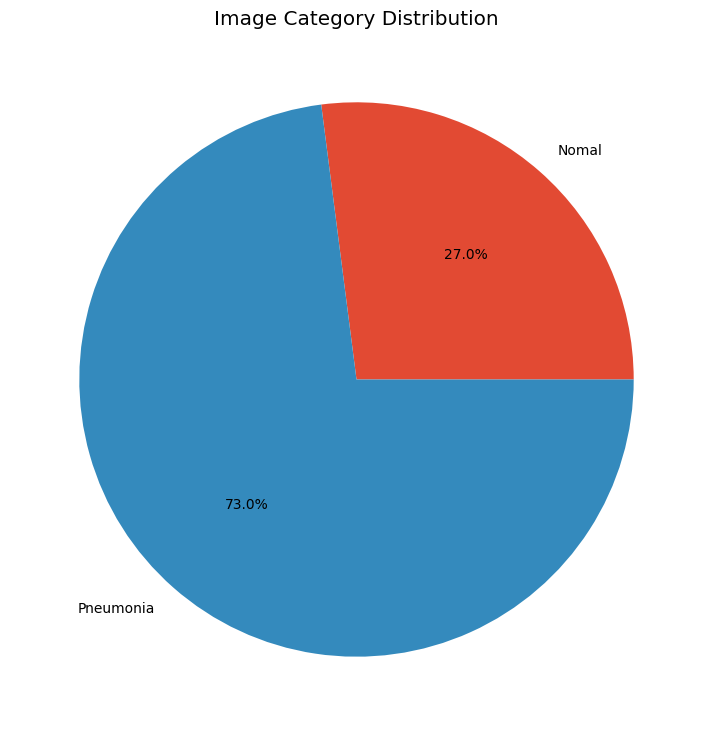

In [15]:
labels = ['Nomal', 'Pneumonia']
targets = [len(all_normal), len(all_pneumonia)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

* We can see that there's some good data imbalance, we have more data for Pneumonia Images then for the Normal Images.

In [16]:
# Shuffle and Get some images into new list
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]

## Basic X-Ray Images


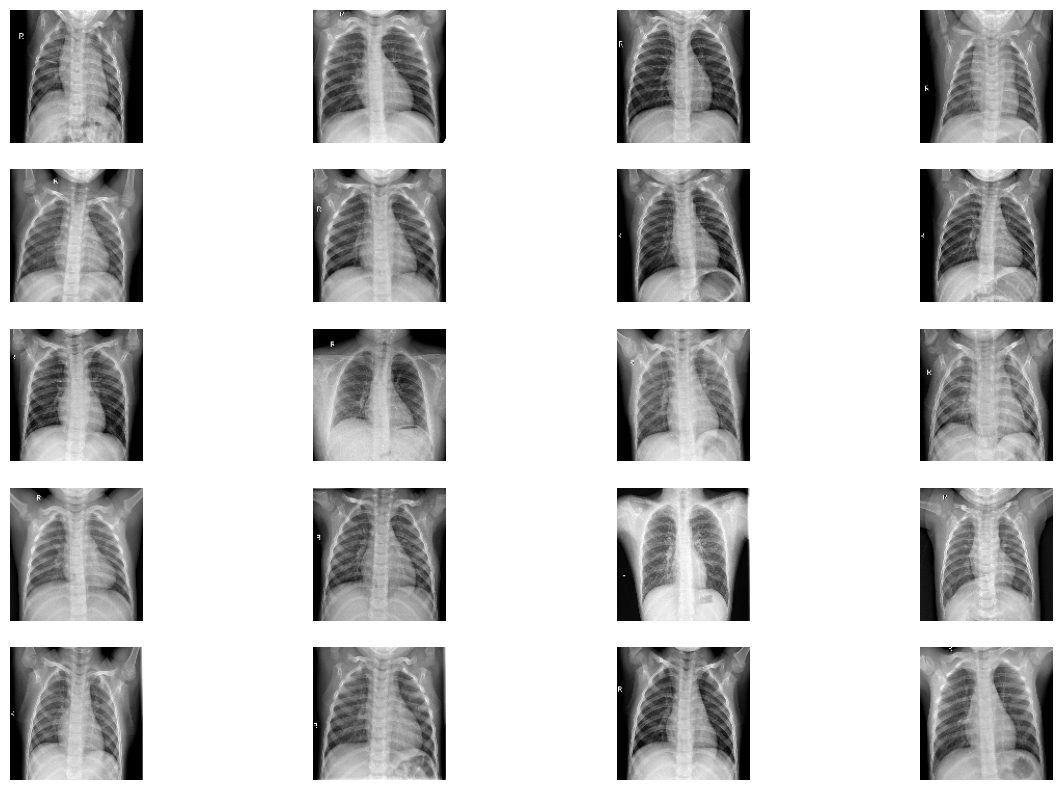

In [17]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 5
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

## Ben Graham's Method


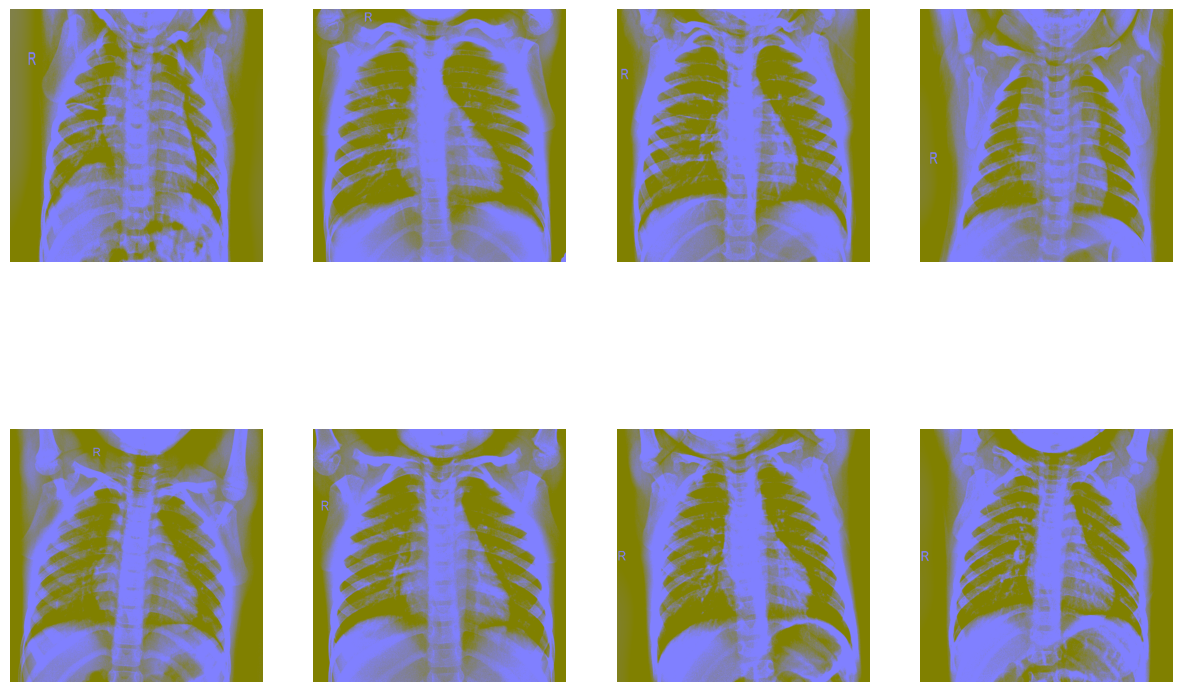

In [18]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

## Fourier Method for Pixel Distribution

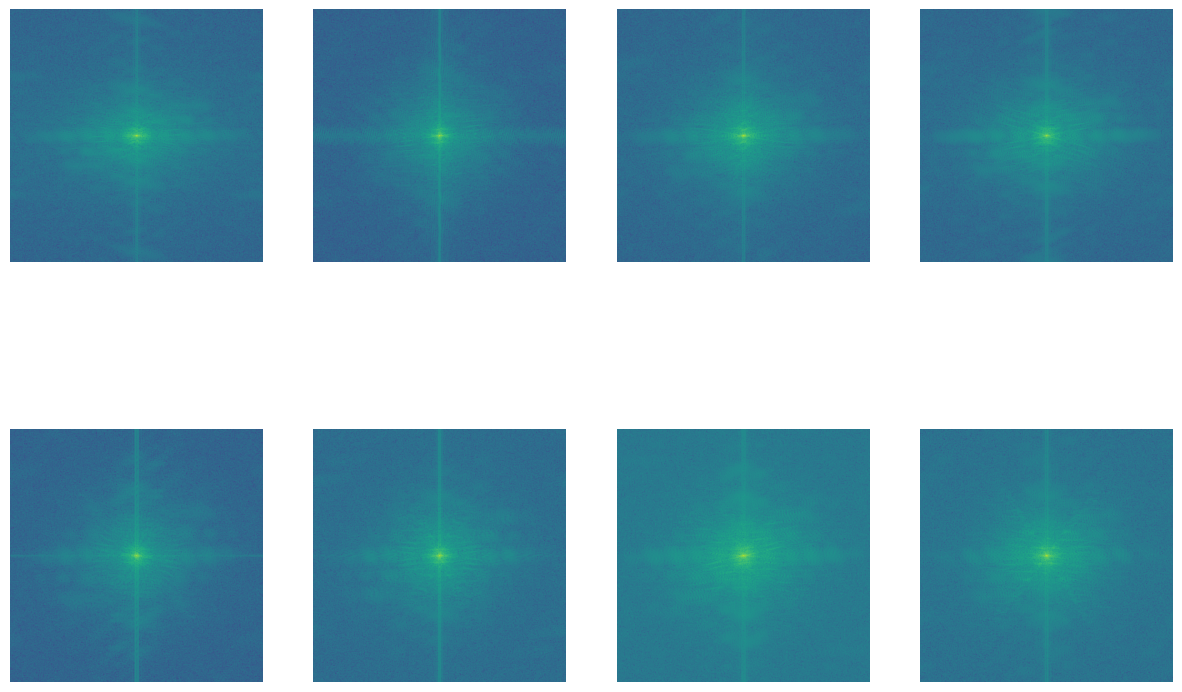

In [19]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

* Those images are basically magnitude spectrums, this helps in understanding where majority of growth is situated.

## Albumentations Visualization

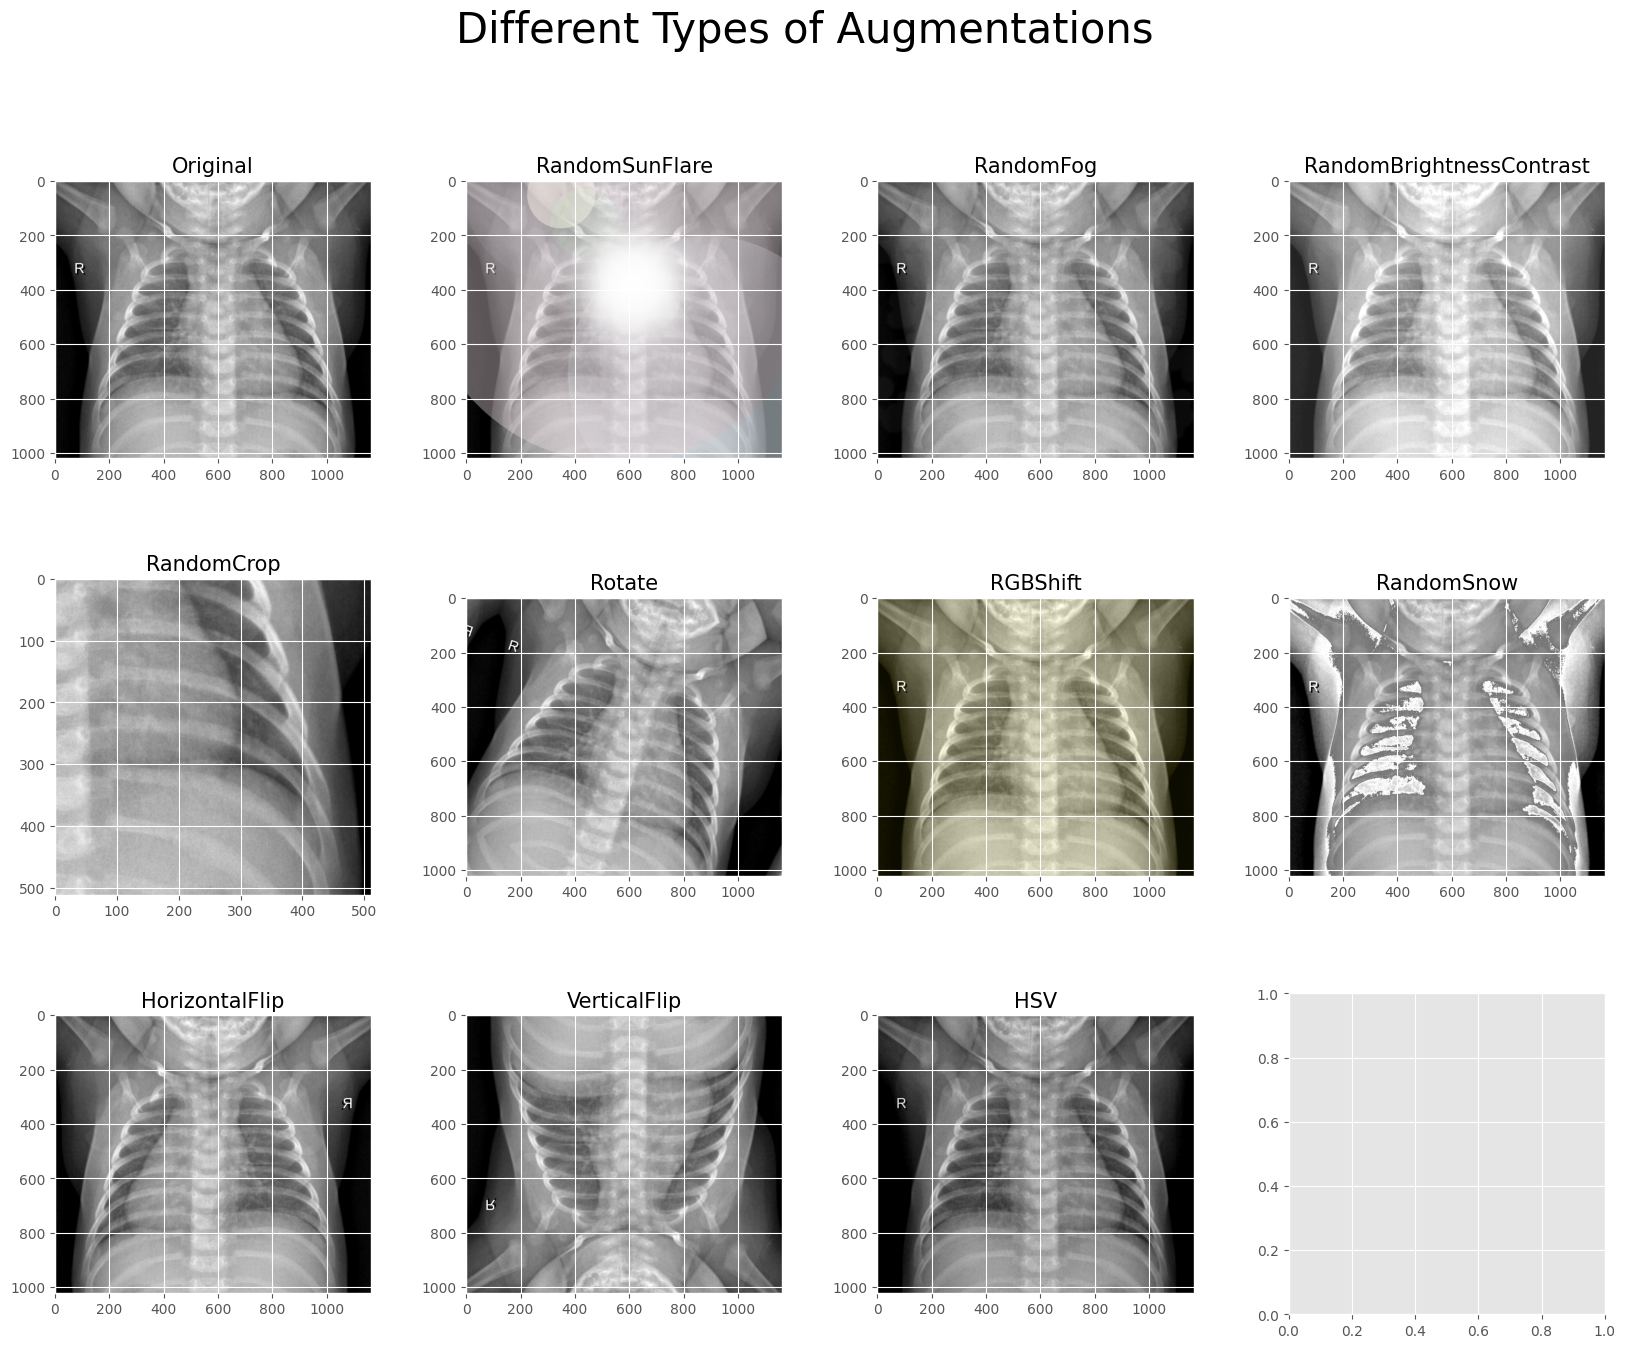

In [20]:
chosen_image = cv2.imread(images[25])

albumentation_list = [
    A.RandomSunFlare(p=1), 
    A.RandomFog(p=1), 
    A.RandomBrightnessContrast(p=1),  # Corrected
    A.RandomCrop(p=1, height=512, width=512), 
    A.Rotate(p=1, limit=90),
    A.RGBShift(p=1), 
    A.RandomSnow(p=1),
    A.HorizontalFlip(p=1), 
    A.VerticalFlip(p=1), 
    A.HueSaturationValue(p=1, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)
]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image=chosen_image)['image']
    img_matrix_list.append(img)

# Include the original image at the start of the list
img_matrix_list.insert(0, chosen_image)

# Updated titles list
titles_list = [
    "Original", "RandomSunFlare", "RandomFog", "RandomBrightnessContrast", 
    "RandomCrop", "Rotate", "RGBShift", "RandomSnow", 
    "HorizontalFlip", "VerticalFlip", "HSV"
]

# Assuming plot_multiple_img is a function to display multiple images
plot_multiple_img(img_matrix_list, titles_list, ncols=4, main_title="Different Types of Augmentations")


## Image Erosion

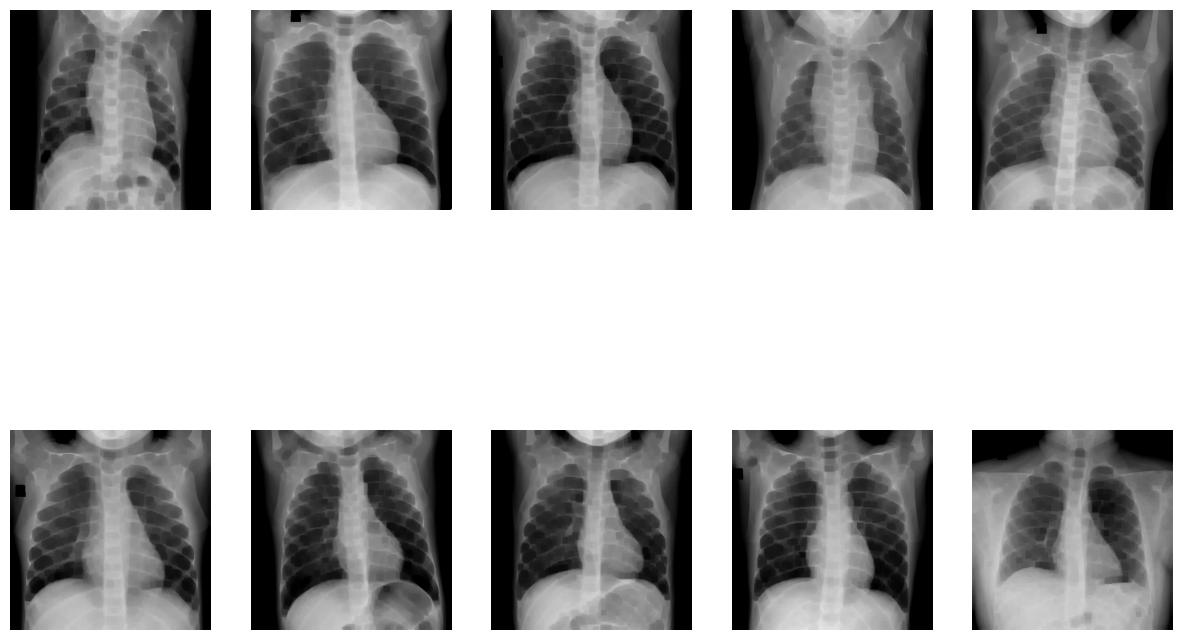

In [21]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

## Image Dilation

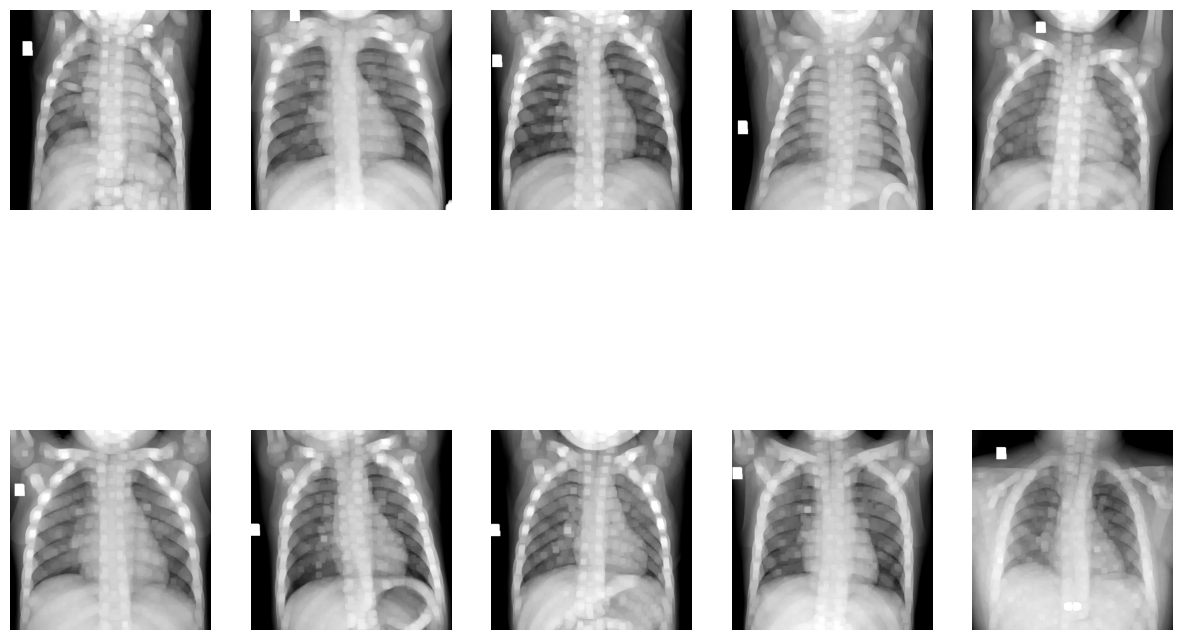

In [22]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

## Canny Edge Detection

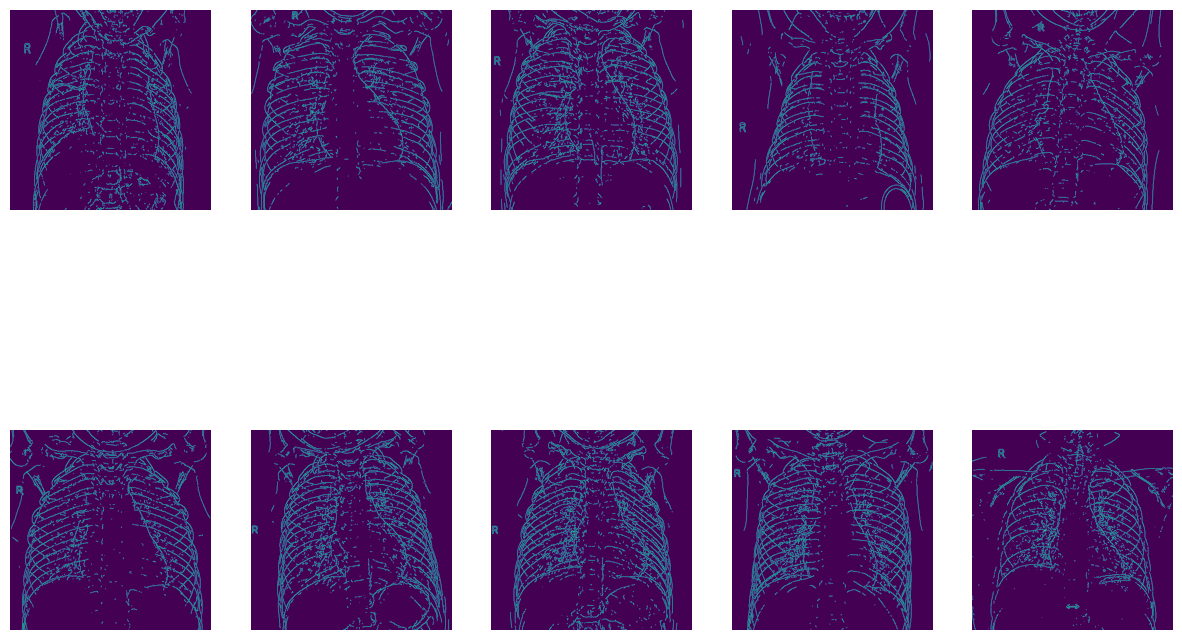

In [23]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

<div style="
  background-color: #e3f2fd;
  padding: 15px;
  border-left: 6px solid #0d47a1;
  border-radius: 8px;
  font-family: 'Georgia', serif;
  color: #01579b;
  font-size: 28px;
  text-align: center;
  font-weight: bold;
">
  🧠 Modeling

</div>

In [2]:
#DISCRIMINATOR
class Discriminator(nn.Module):
    def __init__(self, im_channels, hidden_dim=64):
        super().__init__()
        self.disc = nn.Sequential(
            self._block(im_channels, hidden_dim, 4, 2, 1),       # 128x128 -> 64x64
            self._block(hidden_dim, hidden_dim*2, 4, 2, 1),      # 64x64 -> 32x32
            self._block(hidden_dim*2, hidden_dim*4, 4, 2, 1),    # 32x32 -> 16x16
            self._block(hidden_dim*4, hidden_dim*8, 4, 2, 1),    # 16x16 -> 8x8
            self._block(hidden_dim*8, hidden_dim*16, 4, 2, 1),   # 8x8 -> 4x4
            nn.Conv2d(hidden_dim*16, 1, kernel_size=4, stride=1, padding=0)  # 4x4 -> 1x1
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
# GENERATOR
class Generator(nn.Module):
    def __init__(self, z_dim, im_channels, hidden_dim=64):
        super().__init__()
        self.gen = nn.Sequential(                                    # 1x1 -> 4x4 -> 8x8 -> 16x16 -> 32x32 -> 64x64 -> 128x128
            self._block(z_dim, hidden_dim * 16, 4, 1, 0),            # Latent vector (z_dim) -> 4x4
            self._block(hidden_dim * 16, hidden_dim * 8, 4, 2, 1),   # 4x4 -> 8x8
            self._block(hidden_dim * 8, hidden_dim * 4, 4, 2, 1),    # 8x8 -> 16x16
            self._block(hidden_dim * 4, hidden_dim * 2, 4, 2, 1),    # 16x16 -> 32x32
            self._block(hidden_dim * 2, hidden_dim, 4, 2, 1),        # 32x32 -> 64x64
            nn.ConvTranspose2d(hidden_dim, im_channels, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)

In [4]:
n_epochs = 150
z_dim = 100
img_channels = 1
batch_size = 32
img_size = 128
learning_rate = 0.0002
lambda_gp = 10
n_critic = 5
betas = (0.3, 0.99)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
train_transformer = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(img_channels)], [0.5 for _ in range(img_channels)]),
])

dataset = datasets.ImageFolder(root='/kaggle/input/pneumonia-data', transform=train_transformer)

In [6]:
dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last = True)

In [7]:
gen = Generator(z_dim, img_channels).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=betas)
critic = Discriminator(img_channels).to(device)
critic_opt = torch.optim.Adam(critic.parameters(), lr=learning_rate, betas=betas)

# Initializing weights
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

def gradient_penalty(critic, real, fake):
    epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
    interpolated_images = real * epsilon + fake * (1-epsilon)

    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm-1)**2)
    return gradient_penalty


gen = gen.apply(weights_init)
critic = critic.apply(weights_init)
fixed_noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 10/150 gen_loss: 5.074386534094811, critic_loss: -9.179029259681702


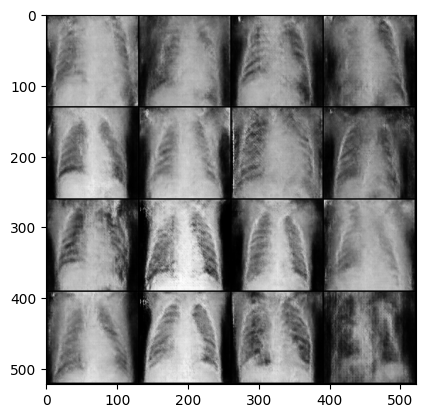

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 20/150 gen_loss: -10.289178848266602, critic_loss: -8.09662941455841


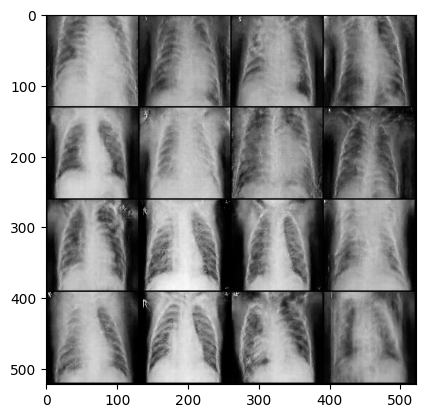

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 30/150 gen_loss: -22.62586326599121, critic_loss: -8.040230209827422


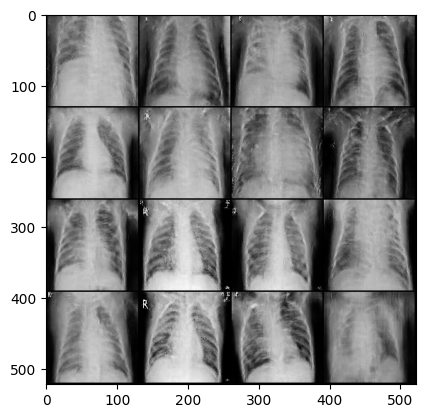

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 40/150 gen_loss: -32.130605125427245, critic_loss: -8.111633334159851


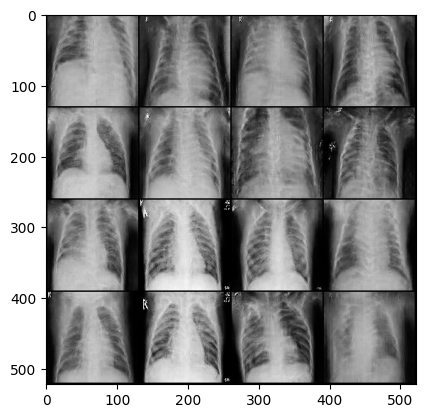

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 50/150 gen_loss: -38.15097312927246, critic_loss: -8.212228560447693


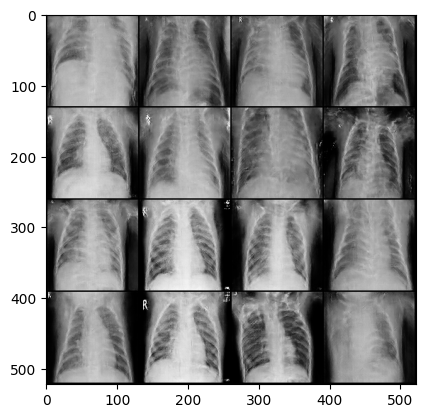

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 60/150 gen_loss: -39.972618865966794, critic_loss: -9.102499957084657


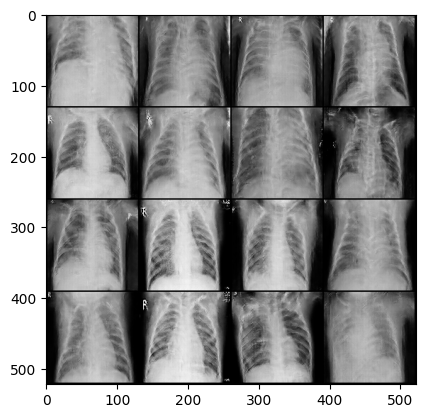

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 70/150 gen_loss: -44.49127731323242, critic_loss: -9.66893111228943


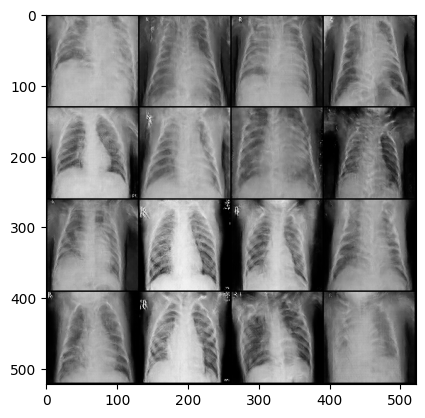

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 80/150 gen_loss: -49.77009048461914, critic_loss: -10.775177245140075


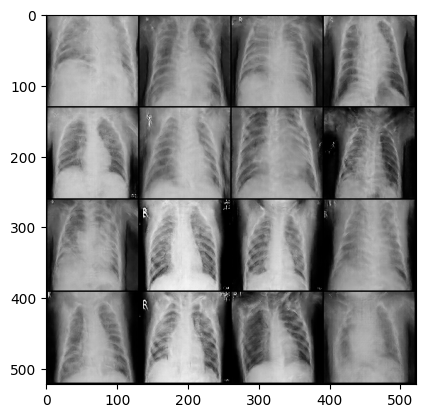

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 90/150 gen_loss: -50.579673767089844, critic_loss: -10.897344818115233


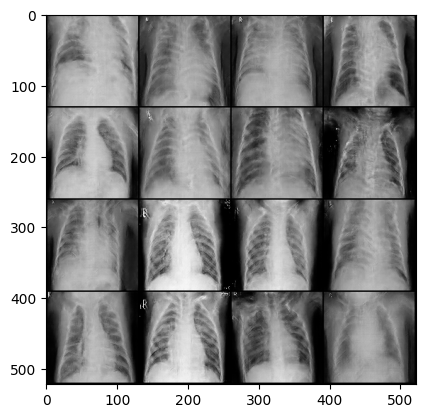

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 100/150 gen_loss: -55.6642951965332, critic_loss: -11.792193403244019


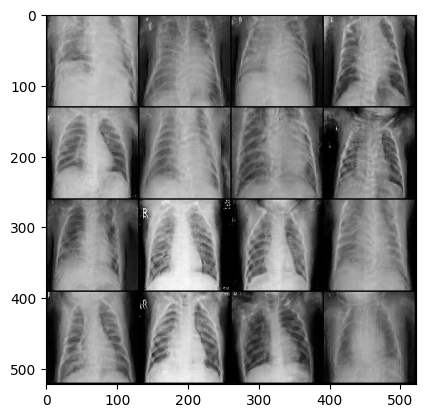

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 110/150 gen_loss: -58.58733367919922, critic_loss: -12.964060373306273


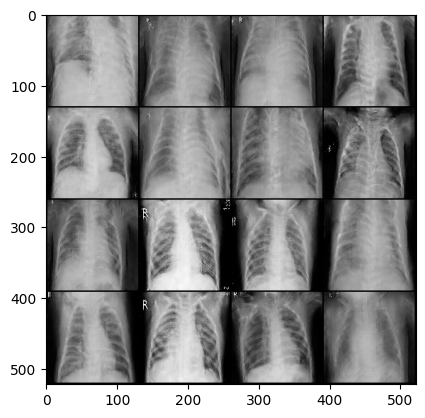

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 120/150 gen_loss: -60.63554992675781, critic_loss: -12.491005096435547


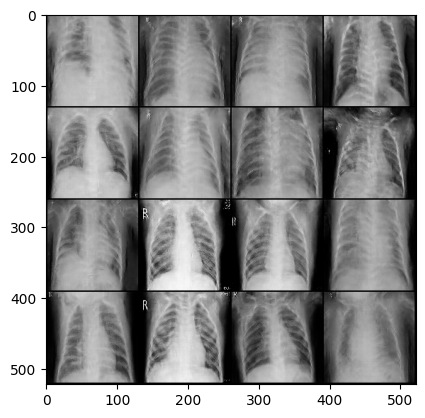

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 130/150 gen_loss: -60.08079833984375, critic_loss: -14.163672485351563


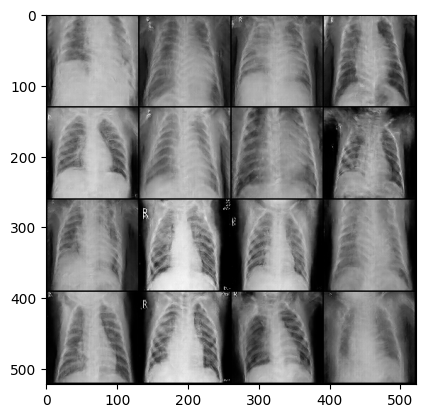

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 140/150 gen_loss: -62.35068893432617, critic_loss: -14.535459308624265


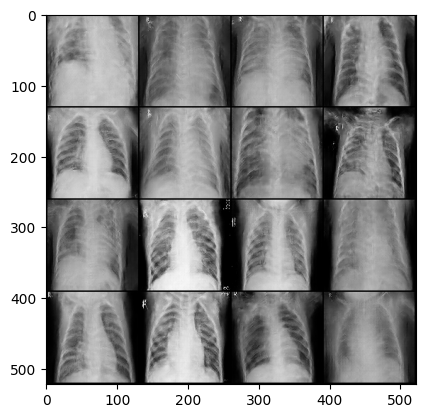

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

Epoch 150/150 gen_loss: -64.03093032836914, critic_loss: -13.99744674682617


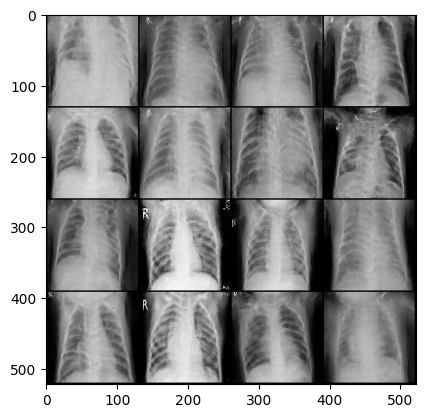

In [8]:
step = 0
display_epoch = 10  # Plot every 10 epochs
gen_losses = []
critic_losses = []
step_bins = 20  # Set the bins for plotting generator and critic loss

for epoch in range(n_epochs):
    batch_idx = 0
    for real, _ in tqdm(dataloader):
        real = real.to(device)
        mean_iteration_critic_loss = 0
        
        for _ in range(n_critic):
            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = gen(noise)

            # critic_training
            crit_real_pred = critic(real)
            crit_fake_pred = critic(fake)
            gp = gradient_penalty(critic, real, fake)
            loss_critic = -(torch.mean(crit_real_pred) - torch.mean(crit_fake_pred)) + lambda_gp * gp
            critic_opt.zero_grad()
            loss_critic.backward(retain_graph=True)
            critic_opt.step()

            mean_iteration_critic_loss += loss_critic.item() / n_critic

        critic_losses.append(mean_iteration_critic_loss)

        # generator_training
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)
        output = critic(fake)
        loss_gen = -torch.mean(output)
        gen_opt.zero_grad()
        loss_gen.backward()
        gen_opt.step()

        gen_losses.append(loss_gen.item())

        batch_idx += 1
        step += 1

    # Plot and save images and losses only every 10 epochs
    if (epoch + 1) % display_epoch == 0:
        gen_mean = sum(gen_losses[-display_epoch:]) / display_epoch
        crit_mean = sum(critic_losses[-display_epoch:]) / display_epoch
        print(f"Epoch {epoch + 1}/{n_epochs} gen_loss: {gen_mean}, critic_loss: {crit_mean}")

        with torch.no_grad():
            # Save and display generated images
            fake_image = gen(fixed_noise)
            img_grid_fake = make_grid(fake_image[:16], nrow=4, normalize=True)
            plt.imshow(img_grid_fake.permute(1, 2, 0).squeeze().cpu())
            plt.savefig(f'/image_at_epoch_{epoch + 1:04d}.png')
            plt.show()

        if step % 200 == 0:
            num_examples = (len(gen_losses) // step_bins) * step_bins

            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(gen_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

In [ ]:
# Save the generator model from the last epoch
torch.save(gen.state_dict(), 'last_epoch_generator.pth')

# Save the critic model from the last epoch
torch.save(critic.state_dict(), 'last_epoch_critic.pth')

print("Models from the last epoch have been saved successfully.")